In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from numba import njit, prange

from matplotlib import pyplot as plt

### Load data

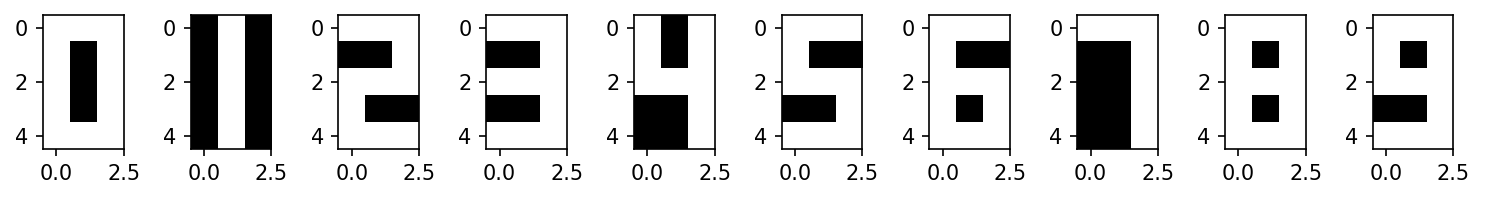

In [2]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

nums_mtrx =  np.loadtxt(Path('data', 'numbers_5x3.txt'))

for n, ax in zip(nums_mtrx, axes.ravel()):
    ax.imshow(n.reshape(5, 3), cmap='binary_r')

plt.tight_layout()
plt.show()

### Generate dataset

In [3]:
cells_columns = [f'c{n}' for n in range(15)]
classes = ['zero','one','two','three','four','five','six','seven','eight','nine']

df = pd.DataFrame(columns=cells_columns+['class'])

for i in range(10):
    new_row = dict(zip(cells_columns, nums_mtrx[i]))
    new_row['class'] = classes[i]
    
    df.loc[df.index.size] = new_row

    for j in range(9):
        noised_num = nums_mtrx[i] + np.random.uniform(0, 0.25, 15)
        
        new_row = dict(zip(cells_columns, noised_num))
        new_row['class'] = classes[i]
        
        df.loc[df.index.size] = new_row

for name in df['class'].unique():
    df[f'{name}_label'] = df['class'].map(lambda x: 1 if x == name else 0)

### Split dataset to test and train

In [4]:
test_frac = 0.7

p = np.arange(10)

test_size = int(p.size*test_frac)
train_size = int(p.size*(1-test_frac))

idx_test = np.ravel([(p[0 : test_size] + i*10) for i in range(10)])
idx_train = np.ravel([(p[test_size : p.size] + i*10) for i in range(10)])

features_columns = cells_columns
label_columns = [f"{name}_label" for name in classes]

x_test = np.array(df.iloc[idx_test][features_columns])
y_test = np.array(df.iloc[idx_test][label_columns])

x_tarin = np.array(df.iloc[idx_train][features_columns])
y_train = np.array(df.iloc[idx_train][label_columns])

### Define activation functions

In [5]:
@njit(fastmath=True)
def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def dRelu(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1/(1+np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1/(1+np.exp(-x))
    return y*(1-y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> float:
    y = np.exp(x)
    return y/np.sum(y)

### Define model

In [6]:
@njit(fastmath=True)
def grads(xBatch: np.ndarray, yBatch: np.ndarray, Wh: np.ndarray, w: np.ndarray, Bh: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    n = xBatch.shape[0]

    dWh = np.zeros(Wh.shape)
    dw = np.zeros(w.shape)
    
    dBh = np.zeros(Bh.shape)
    db = np.zeros(b.shape)
    
    for i in prange(n):
        Uh = xBatch[i] @ Wh + Bh
        h = relu(Uh)
        y = softmax(h @ w + b)

        dw += np.outer(h, y - yBatch[i])
        db += y - yBatch[i]
        
        dWh += np.outer(xBatch[i] ,(y - yBatch[i]) @ w.T * dRelu(Uh))
        dBh += (y - yBatch[i]) @ w.T * dRelu(Uh)
    
    return (dWh, dw, dBh, db)

class Perceptron:
    def __init__(self, nIn: int, nHidden: int, nOut: int) -> None:
        self.nIn = nIn
        self.nHidden = nHidden
        self.nOut = nOut
        
        self.Wh: np.ndarray = np.random.uniform(-1, 1, (nIn, nHidden))
        self.w: np.ndarray = np.random.uniform(-1, 1, (nHidden, nOut))
        
        self.Bh: np.ndarray = np.zeros((nHidden))
        self.b: np.ndarray = np.zeros((nOut))

    def predict(self, x:np.ndarray) -> np.ndarray:
        h = relu(x @ self.Wh + self.Bh)
        return softmax(h @ self.w + self.b)

    def train(self, xTrain: np.ndarray, yTrain: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = xTrain.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for i in range(n//batch_size):
                ibegin, iend = i*batch_size, min((i+1)*batch_size, n-1)
                batch_idxs = idxs[ibegin:iend]

                dWh, dw, dBh, db = grads(xTrain[batch_idxs], yTrain[batch_idxs], self.Wh, self.w, self.Bh, self.b)

                self.Wh -= lr*dWh
                self.w -= lr*dw

                self.Bh -= lr*dBh
                self.b -= lr*db

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:        
        ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y*np.log(ypred), axis=1)
        return np.mean(h)

### Create and train model

In [7]:
nIn = 15
nHidden = 15
nOut = 10

learning_rate = 1e-2
batch_size = 8
max_epoch = 5000

model = Perceptron(nIn, nHidden, nOut)

print('untrained loss: ', model.loss(x_test, y_test).round(3))

model.train(
    x_tarin,
    y_train,
    learning_rate,
    batch_size,
    max_epoch
)

print('trained loss: ', model.loss(x_test, y_test).round(3))

TP_count = 0
for x, y in zip(x_test, y_test):
    yPred = model.predict(x)
    TP_count += 1 if np.argmax(y) == np.argmax(yPred) else 0

accuracy = TP_count / x_test.shape[0]
print(f"test set accuracy: {round(accuracy*100, 2)}%")

untrained loss:  0.536
trained loss:  0.0
test set accuracy: 100.0%


### Test model on big number of noised samples

In [8]:
n_samples = 20000
noise_size = 0.5

TP_count = 0

for i in range(n_samples):
    j = i%10
    x = nums_mtrx[j] + np.random.uniform(0, noise_size, 15)
    yPred = model.predict(x)
    TP_count += 1 if j == np.argmax(yPred) else 0

print(f"accuracy: {round(TP_count/n_samples*100, 2)}% ({TP_count} of {n_samples})")

accuracy: 99.45% (19891 of 20000)


### Visualize model predictions

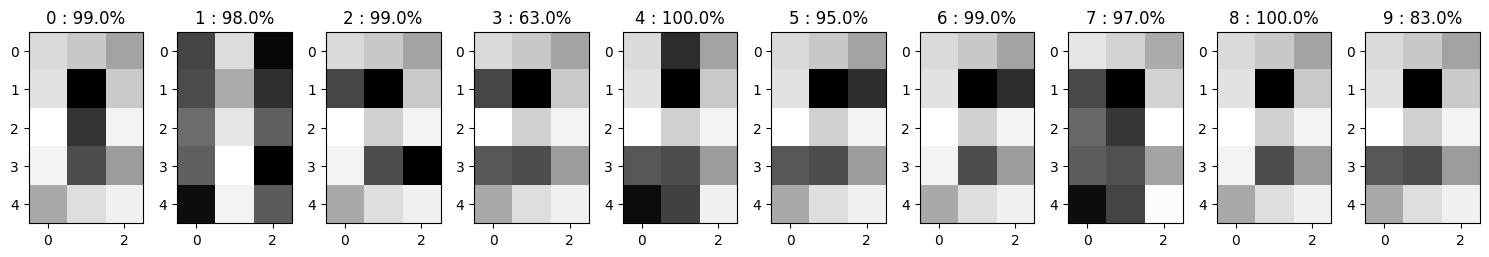

In [9]:
noise_size = 0.75
x_noised = nums_mtrx + np.random.uniform(0, noise_size, 15)

yPred = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape((5,3)),  cmap='binary_r')
    j = np.argmax(yPred[i])
    ax.set_title(f"{j} : {(yPred[i][j]*100).round()}%")

plt.tight_layout()
plt.show()